<a href="https://colab.research.google.com/github/isottongloria/PMLS_Bio-Learning/blob/main/scripts/multilayer_bio_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised learning by competing hidden units**

 ### Author

 - Gloria Isotton
 - Master degree in Physics of data

### Introduction

In this notebook, we extend the approach presented in the paper to develop a more sophisticated unsupervised learning framework capable of training a **multi-layer network**. The goal is to leverage the unsupervised learning paradigm in a more complex network structure while incorporating **static excitatory and inhibitory synaptic connections** to improve the realism and performance of the model.

The extension involves multiple layers of neurons, where each layer learns independently in an unsupervised manner, with connections between layers being modulated by excitatory and inhibitory synapses. This setup mimics the dynamics of biological neural networks more closely, where the balance between excitation and inhibition plays a crucial role in network stability, learning efficiency, and the emergence of meaningful representations.

In the following sections, we will present the modifications made to the original framework, explain the design choices for synaptic regulation, and showcase the performance of the multi-layer model on several benchmark datasets. The code and the experiments demonstrate how unsupervised learning can be scaled to deeper architectures while preserving biological plausibility through synaptic balance.

In [1]:
# Importing dependencies

import torch
import torchvision
from PIL import Image
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import MultiStepLR
import os


In [2]:
# Cuda Parameters
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
device = torch.device("cuda" if use_cuda else "cpu")

## Dataset loading
Variable containing the dataset name `data_name`:
- `1` : MNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?ref=hackernoon.com#torchvision.datasets.MNIST <br>
- `2` : CIFAR10 https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html?ref=hackernoon.com#torchvision.datasets.CIFAR10<br>
- `3` : FashionMNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html?ref=hackernoon.com#torchvision.datasets.FashionMNIST<br>

In [3]:
data_name=3

####### MNIST dataset ########
if data_name == 1:
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.view(-1))])
    full_train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)

    train_size = 50000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=28, shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")


####### CIFAR10 dataset ########
if data_name == 2:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.Lambda(lambda x: x.view(-1))])
    full_train_dataset = datasets.CIFAR10(root="data", download=True, train=True, transform=transform)

    train_size = 40000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")



####### FASHION MNIST dataset ########
if data_name == 3:
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),
                                   transforms.Lambda(lambda x: x.view(-1))])

    full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)
    train_size = 50000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=28,shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=28,shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")



Training set size: 50000
Test set size: 10000


# **Single layer unsupervised training**

In [4]:
def unsupervised_bio_learning(train_dataset, initial_synapses, n_hidden=28, n_epochs=500, batch_size=100,
                              learning_rate=0.01, precision=0.1,
                              anti_hebbian_learning_strength=0.3,
                              lebesgue_norm=2, rank=5, skip=1):
    """
    Unsupervised bio learning function.

    Parameters:
    - train_dataset: Input dataset (torch.Tensor), where each row is a training example.
    - n_input: number of input neurons
    - n_hidden: Number of hidden units (neurons).
    - n_epochs: Number of epochs to train the model.
    - batch_size: The size of the minibatch used to update the weights.
    - learning_rate: Initial learning rate that decreases over epochs.
    - precision: A threshold to normalize the gradient to avoid very small updates.
    - anti_hebbian_learning_strength: Strength of anti-Hebbian learning (penalizing neurons with low activation).
    - lebesgue_norm: Parameter for the Lebesgue norm used to weigh the contributions of the weights.
    - rank: Number of hidden neurons that are penalized using anti-Hebbian learning.
    - skip: Print the number of epochs every skip-times.
    """

    # Flatten the input data and determine input size
    input_data = torch.stack([data[0].flatten() for data in train_dataset]).to(device)
    n_input = input_data.shape[1]  # Number of input neurons

    # Initialize synapse weights
    synapses = torch.rand((n_hidden, n_input), dtype=torch.float, device=device)

    if initial_synapses is not None:
        synapses = initial_synapses.to(device)

    # Loop over epochs
    for epoch in range(n_epochs):
        if (epoch % skip == 0):
            print('Epoch -->', epoch)

        eps = learning_rate * (1 - epoch / n_epochs)  # Decaying learning rate

        # Shuffle dataset once for the entire epoch
        shuffled_epoch_data = input_data[torch.randperm(input_data.shape[0]), :]

        # Loop through minibatches
        for i in range(0, len(train_dataset), batch_size):
            mini_batch = shuffled_epoch_data[i:i + batch_size, :].to(device)
            mini_batch = mini_batch.transpose(0, 1)  # Transpose for correct shape (n_input, batch_size)

            # --- Currents --- #
            sign = torch.sign(synapses).to(device)  # Sign of weights
            tot_input = torch.mm(sign*torch.abs(synapses).pow(lebesgue_norm-1), mini_batch) # Weight matrix raised to the power of (p-1)
                                                                               # Compute the total input to the hidden layer
            # --- Activation --- #
            y = torch.argsort(tot_input, dim=0).to(device)  # Sort activations

            # Initialize the Hebbian and anti-Hebbian activations matrix
            yl = torch.zeros((n_hidden, batch_size)).to(device)

            # Apply Hebbian learning (max activation)
            yl[y[n_hidden - 1, :], torch.arange(batch_size, device=device)] = 1.0

            # Apply anti-Hebbian learning (penalize lowest activations)
            yl[y[n_hidden - rank, :], torch.arange(batch_size, device=device)] = -anti_hebbian_learning_strength

            # Compute the contribution of the activations on the total input received
            xx = torch.sum(torch.mul(yl, tot_input), 1)  # Sum over batch dimension

            # --- Compute change of weights --- #
            #ds = torch.mm(yl, mini_batch.transpose(0, 1)) - xx * synapses
            ds = torch.matmul(yl, torch.transpose(mini_batch, 0, 1)) - torch.mul(xx.reshape(xx.shape[0],1).repeat(1, n_input), synapses)

            # Normalize the gradient to prevent very large or very small updates
            nc = torch.max(torch.abs(ds))
            if nc < precision:
                nc = precision

            # Update the synapse weights
            synapses += torch.mul(torch.div(ds, nc), eps)

    return synapses


In [ ]:
synapses = unsupervised_bio_learning(train_dataset,initial_synapses=None, n_hidden=2000, n_epochs=1000, batch_size=100,
                              learning_rate=0.01, precision=0.1,
                              anti_hebbian_learning_strength=0.3,
                              lebesgue_norm=2, rank=2, skip=1)

Epoch --> 0
Epoch --> 1
Epoch --> 2
Epoch --> 3
Epoch --> 4
Epoch --> 5
Epoch --> 6
Epoch --> 7
Epoch --> 8
Epoch --> 9
Epoch --> 10
Epoch --> 11
Epoch --> 12
Epoch --> 13
Epoch --> 14
Epoch --> 15
Epoch --> 16
Epoch --> 17
Epoch --> 18
Epoch --> 19
Epoch --> 20
Epoch --> 21
Epoch --> 22
Epoch --> 23
Epoch --> 24
Epoch --> 25
Epoch --> 26
Epoch --> 27
Epoch --> 28
Epoch --> 29
Epoch --> 30
Epoch --> 31
Epoch --> 32
Epoch --> 33
Epoch --> 34
Epoch --> 35
Epoch --> 36
Epoch --> 37
Epoch --> 38
Epoch --> 39
Epoch --> 40
Epoch --> 41
Epoch --> 42
Epoch --> 43
Epoch --> 44
Epoch --> 45
Epoch --> 46
Epoch --> 47
Epoch --> 48
Epoch --> 49
Epoch --> 50
Epoch --> 51
Epoch --> 52
Epoch --> 53
Epoch --> 54
Epoch --> 55
Epoch --> 56
Epoch --> 57
Epoch --> 58
Epoch --> 59
Epoch --> 60
Epoch --> 61
Epoch --> 62
Epoch --> 63
Epoch --> 64
Epoch --> 65
Epoch --> 66
Epoch --> 67
Epoch --> 68
Epoch --> 69
Epoch --> 70
Epoch --> 71
Epoch --> 72
Epoch --> 73
Epoch --> 74
Epoch --> 75
Epoch --> 76
Epoch -->

# Final layer supervised training

In [23]:
class BioClassifier(nn.Module):
    def __init__(self, W_unsupervised, layers_config, out_features):
        super(BioClassifier, self).__init__()

        self.W_unsupervised = nn.Parameter(W_unsupervised.T, requires_grad=False)  # Transpose to shape (784, hidden_dim)

        self.layers = nn.Sequential()

        # Input size is the number of neurons in unsupervised weights
        input_size = W_unsupervised.size(0)

        # Create multiple hidden layers as per `layers_config`
        for idx, layer_size in enumerate(layers_config):
            self.layers.add_module(f'linear_{idx}', nn.Linear(input_size, layer_size))
            self.layers.add_module(f'batchnorm_{idx}', nn.BatchNorm1d(layer_size))
            self.layers.add_module(f'relu_{idx}', nn.ReLU())
            input_size = layer_size

        # Output layer
        self.output_layer = nn.Linear(input_size, out_features)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward through unsupervised weights
        x = torch.matmul(x, self.W_unsupervised)  # Resulting shape should be (batch_size, input_dim)

        # Forward through the hidden layers
        x = self.layers(x)

        # Output layer
        x = self.output_layer(x)
        return self.softmax(x)


def train_bio_classifier(W_unsupervised, train_loader, val_loader, correct_img_bzs, data_name, layers_config, out_features, n_epochs, batch_size, anti_hebbian_learning_strength,
                       lebesgue_norm, rank):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Clone initial unsupervised weights for verification
    W_initial = W_unsupervised.clone().detach()
    W_unsupervised.requires_grad = False

    # Initialize BioClassifier with frozen W_unsupervised and multiple layers
    model = BioClassifier(W_unsupervised, layers_config, out_features).to(device)

    # Define the loss function
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Scheduler setup
    scheduler = MultiStepLR(optimizer, milestones=[100, 150, 200, 250], gamma=0.5)

    # Lists for logging
    train_loss_log, val_loss_log, train_acc_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        total_loss, correct = 0, 0

        for images, labels in train_loader:
            if images.shape[0] != correct_img_bzs:
                print(f"Batch scartato per dimensione errata: {images.shape}")
                continue

            images = images.view(batch_size, -1).to(device)  # Flatten images to (batch_size, img_sz)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        train_loss = total_loss / len(train_loader.dataset)
        train_accuracy = correct / len(train_loader.dataset)

        # Store training logs
        train_loss_log.append(train_loss)
        train_acc_log.append(train_accuracy)

        # Validation every epochs
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}")

        # Scheduler step
        scheduler.step()

    # Verify unsupervised weights remain unchanged
    if torch.equal(W_unsupervised, W_initial):
        print("Unsupervised weights remained unchanged during supervised training.")
    else:
        print("Warning: Unsupervised weights were modified during supervised training.")


    # Plotting
    # Dizionario dei nomi dei dataset
    data_name_dict = {1: "MNIST", 2: "CIFAR10", 3: "FashionMNIST"}
    dataset_name = data_name_dict.get(data_name, "UnknownDataset")

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), train_loss_log, '.-', label='Train Loss', color='red', lw=2, alpha=0.5)
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), val_loss_log, '.-', label='Val Loss', color='blue', lw=2, alpha=0.5)
    plt.title(f'Training and Validation Loss for {n_hidden} hidden units on {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'output/{dataset_name}_biolinear_{n_hidden}hu_{out_features}out_{n_epochs}ep_ahls{anti_hebbian_learning_strength}_lnorm{lebesgue_norm}_rank{rank}_loss.png')
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), train_acc_log, '.-', label='Train Accuracy', color='red', lw=2, alpha=0.5)
    plt.plot(np.linspace(0, len(val_loss_log), len(val_loss_log)), val_acc_log, '.-', label='Val Accuracy', color='blue', lw=2, alpha=0.5)
    plt.title(f'Training and Validation Accuracy for {n_hidden} hidden units on {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'content/{dataset_name}_biolinear_{n_hidden}hu_{out_features}out_{n_epochs}ep_ahls{anti_hebbian_learning_strength}_lnorm{lebesgue_norm}_rank{rank}_acc.png')
    plt.show()

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log


def validate(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    # Disable gradient calculations for validation
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.size(0), -1).to(device)  # Flatten images and move to device
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total

    return avg_loss, accuracy

## Draw weights

In [9]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1

    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max()
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    fig.canvas.draw()

# %matplotlib inline
#fig=plt.figure(figsize=(10, 7))
#draw_weights(synapses, 20, 10) # .to('cpu')
#plt.tight_layout()

# **Multi layer linear bio classifier**

The Multilayer Pipeline Bio Learner extends the single-layer model into multiple layers, forming a sequential processing pipeline. Each layer is trained independently using the same biologically inspired learning mechanism.
The output of one layer becomes the input for the next, allowing for progressively more complex feature extraction. Finally, a fully connected layer is added on top, trained using backpropagation to specialize the model for a specific task (image classification) or prediction.

![Multilayer Image](https://raw.githubusercontent.com/isottongloria/PMLS_Bio-Learning/main/multilayer.png)


In [6]:
# BioClassifier: the supervised classifier model with frozen unsupervised weights W
class BioInference(nn.Module):
    def __init__(self, W, out_features=10, n=4.5, beta=0.01):
        super().__init__()

        self.W = W.transpose(0, 1)
        self.n = n
        self.beta = beta

        # Linear layer for supervised weights S (from hidden to output)
        self.S = nn.Linear(W.size(0), out_features, bias=False)  # S learns during supervised phase

    def forward(self, v):
        # Move input v to the same device as self.W
        v = v.to(self.W.device)

        # Apply the frozen weights W
        Wv = torch.matmul(v, self.W)  # (batch_sz, n_filters)
        h = F.relu(Wv) ** self.n  # Apply nonlinearity with n exponent
        Sh = self.S(h)  # Supervised layer S
        c = torch.tanh(self.beta * Sh)  # Final output with tanh
        return c


def multi_layer_unsupervised_bio_learning(train_dataset, layers_config, n_epochs, batch_size,
                                          learning_rate, precision, anti_hebbian_learning_strength,
                                          lebesgue_norm, rank):
    """
    Trains a multi-layer unsupervised model using a layer-wise approach.

    Parameters:
    - train_dataset: Input dataset (torch.Tensor), where each row is a training example.
    - layers_config: A list with the number of hidden units for each layer.
    - Other parameters are the same as for the unsupervised_bio_learning_layer function.

    Returns:
    - synapses_list: List of trained weights for each layer.
    """

    synapses_list = []

    # The number of input units for the current layer is the number of features from the previous layer
    input_data = torch.stack([data[0].flatten() for data in train_dataset])
    n_input = input_data.shape[1]
    input_data = input_data.to(device)

    for idx in range(len(layers_config)):

        # number of output neurons/hidden layers
        n_hidden = layers_config[idx]
        print(f"Training layer {idx + 1} with {n_hidden} hidden units.")
        print(f"Training with {n_input} input units.")

        # compute the unsupervised weights
        synapses = unsupervised_bio_learning(train_dataset,initial_synapses=None, n_hidden=n_hidden, n_epochs=n_epochs, batch_size=batch_size,
                                              learning_rate=learning_rate, precision=precision, anti_hebbian_learning_strength=anti_hebbian_learning_strength,
                                              lebesgue_norm=lebesgue_norm, rank=rank, skip=1)

        synapses_list.append(synapses)

        # Do a forward pass to infer the next input == 'train_dataset'
        model = BioInference(synapses, out_features=n_hidden).to(device)
        outputs = model(input_data)

        n_input = outputs.shape[1]  # Pass the output to the next layer
        print('next input', n_input)
        restored_dataset = TensorDataset(outputs)   #.view(-1, 1, 28, 28)

        # Update variables
        train_dataset = restored_dataset
        input_data = torch.stack([data[0].flatten().to(device) for data in train_dataset])

    return synapses_list  # Return the list of all layers' weights


In [7]:
def multi_layer_unsupervised_bio_learning(train_dataset, layers_config, n_epochs, batch_size,
                                          learning_rate, precision, anti_hebbian_learning_strength,
                                          lebesgue_norm, rank):
    """
    Trains a multi-layer unsupervised model using a layer-wise approach.

    Parameters:
    - train_dataset: Input dataset (torch.Tensor), where each row is a training example.
    - layers_config: A list with the number of hidden units for each layer.
    - Other parameters are the same as for the unsupervised_bio_learning_layer function.

    Returns:
    - synapses_list: List of trained weights for each layer.
    """

    synapses_list = []

    # Prepare initial input data on GPU
    input_data = torch.stack([data[0].flatten() for data in train_dataset]).to(device)
    n_input = input_data.shape[1]

    for idx in range(len(layers_config)):
        # Number of output neurons/hidden units
        n_hidden = layers_config[idx]
        print(f"Training layer {idx + 1} with {n_hidden} hidden units.")
        print(f"Training with {n_input} input units.")

        # Compute the unsupervised weights
        synapses = unsupervised_bio_learning(
            train_dataset,
            initial_synapses=None,
            n_hidden=n_hidden,
            n_epochs=n_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            precision=precision,
            anti_hebbian_learning_strength=anti_hebbian_learning_strength,
            lebesgue_norm=lebesgue_norm,
            rank=rank,
            skip=1
        )

        synapses_list.append(synapses)

        # Perform forward pass for the next input (inference)
        with torch.no_grad():  # Disable gradient computation for inference
            model = BioInference(synapses, out_features=n_hidden).to(device)
            outputs = model(input_data)

        # Free up the memory of previous input data
        del input_data
        torch.cuda.empty_cache()

        # Update input for the next layer
        n_input = outputs.shape[1]
        print('next input', n_input)

        # Move output to CPU to free up GPU memory before the next iteration
        outputs = outputs.to('cpu')
        restored_dataset = TensorDataset(outputs)

        # Free the GPU memory of the model
        del model
        torch.cuda.empty_cache()

        # Update input data for the next iteration
        train_dataset = restored_dataset
        input_data = torch.stack([data[0].flatten() for data in train_dataset]).to(device)

    train_dataset_return = train_dataset
    return synapses_list, train_dataset_return  # Return the list of all layers' weights


## FashionMNIST dataset

In [8]:
# Fixed parameters in common to all unsupervised layers
lebesgue_norm = 2
rank = 2
n_epochs_unsupervised = 5
batch_size = 10
learning_rate = 0.01
precision = 0.1
anti_hebbian_learning_strength = 0.4
layers_config = [1000, 500, 100] # number of output neurons for each unsupervised layer

# Output aesthetics parameters
skip = 1
Kx = 10
Ky = 10

synapses_list,train_dataset_final = multi_layer_unsupervised_bio_learning(train_dataset, layers_config, n_epochs_unsupervised, batch_size,
                                          learning_rate, precision, anti_hebbian_learning_strength,
                                          lebesgue_norm, rank)

Training layer 1 with 1000 hidden units.
Training with 784 input units.
Epoch --> 0
Epoch --> 1
Epoch --> 2
Epoch --> 3
Epoch --> 4
next input 1000
Training layer 2 with 500 hidden units.
Training with 1000 input units.
Epoch --> 0
Epoch --> 1
Epoch --> 2
Epoch --> 3
Epoch --> 4
next input 500
Training layer 3 with 100 hidden units.
Training with 500 input units.
Epoch --> 0
Epoch --> 1
Epoch --> 2
Epoch --> 3
Epoch --> 4
next input 100


In [15]:
#fig=plt.figure(figsize=(10, 7))
#draw_weights(synapses_list[2].to('cpu'), 10, 10)
#plt.tight_layout()

Batch scartato per dimensione errata: torch.Size([20, 784])
Epoch [1/2], Train Loss: 2.0088, Val Loss: 2.1367, Train Acc: 0.4610, Val Acc: 0.3247
Batch scartato per dimensione errata: torch.Size([20, 784])
Epoch [2/2], Train Loss: 1.9168, Val Loss: 2.0413, Train Acc: 0.5552, Val Acc: 0.4067
Unsupervised weights remained unchanged during supervised training.


FileNotFoundError: [Errno 2] No such file or directory: '/content/output/FashionMNIST_biolinear_100hu_10out_2ep_ahls0.4_lnorm2_rank2_loss.png'

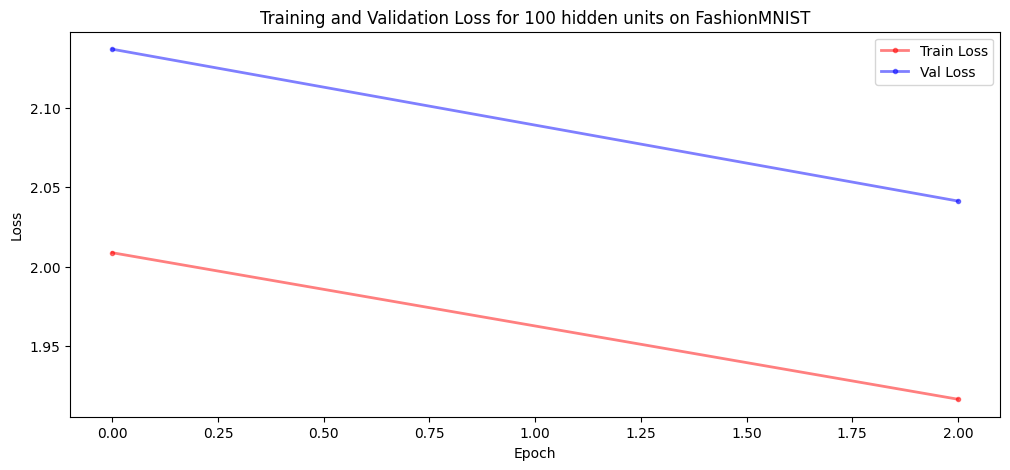

In [24]:
# Fixed parameters for supervised learning
out_features = 10
n_epochs_supervised = 2
batch_size_supervised = 28
correct_img_bzs = 28
n_hidden = layers_config[-1]

# Supervised learning phase
train_loss_log, val_loss_log, train_acc_log, val_acc_log = train_bio_classifier(
    W_unsupervised=synapses_list[0],
    train_loader=train_loader,
    val_loader=test_loader,
    correct_img_bzs=correct_img_bzs,
    data_name=data_name,
    layers_config = layers_config,
    out_features=out_features,
    n_epochs=n_epochs_supervised,
    batch_size=batch_size_supervised,
    anti_hebbian_learning_strength=anti_hebbian_learning_strength,
    lebesgue_norm=lebesgue_norm,
    rank=rank
)